In [1]:
# Let's do the overlapping windows here - We may need to pass the data though a generator to solve the memory issues

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generator import DataGenerator

2025-07-15 19:31:14.200556: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 19:31:15.390117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 19:31:15.390175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 19:31:15.616762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 19:31:15.882615: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# First import the train and validation data

X_train = np.load("data/Overlapping_data/Train_features_and_targets/all_train_features.npy")
X_valid = np.load("data/Overlapping_data/Valid_features_and_targets/all_valid_features.npy")

In [4]:
X_train.shape, X_valid.shape

((49152, 13, 32, 32, 3), (12288, 13, 32, 32, 3))

In [5]:
y_train = np.load("data/Overlapping_data/Train_features_and_targets/all_train_targets.npy")
y_valid = np.load("data/Overlapping_data/Valid_features_and_targets/all_valid_targets.npy")

In [6]:
y_train.shape, y_valid.shape

((49152, 7, 32), (12288, 7, 32))

In [7]:
# Let's redefine the model here

In [8]:
# We need our CNN model
CNN_model = tf.keras.models.load_model('../../Spring_2024/Bayes_for_comps/TS_bayes_implementation_for_TN/models/trained_gmp_model_dense_32_new.h5')

2025-07-15 19:33:05.889671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0


In [9]:
# Define the reduced model

# last layer
output_reduced = CNN_model.layers[-11].output

reduced_model = tf.keras.models.Model(inputs = CNN_model.input, outputs = output_reduced)

reduced_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                             

In [10]:
# okay, now need to add back the dropout, the dense and activation

# add dropout
added_dropout = tf.keras.layers.Dropout(0.5, name = "New_dropout_0")(CNN_model.layers[-11].output)

# add global max pooling
added_flatten = tf.keras.layers.GlobalMaxPooling2D()(added_dropout)

# add dense
added_dense = tf.keras.layers.Dense(64, name = "New_Dense_0")(added_flatten)

# add activation
added_Act = tf.keras.layers.Activation('relu', name = "New_Activation_0")(added_dense)

# add dropout
added_dropout2 = tf.keras.layers.Dropout(0.5, name = "New_dropout_1")(added_Act)

# # add another dense
added_dense_1 = tf.keras.layers.Dense(32, name = "New_Dense_1")(added_dropout2)

# # add activation
added_Act_1 = tf.keras.layers.Activation('relu', name = "New_Activation_1")(added_dense_1)

new_model = tf.keras.models.Model(CNN_model.input, added_Act_1)

In [11]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [12]:
# Pass this thorugh the TD layer, and add the rest of the encoder decoder model for our exercise
input_time = 13
feature_size = 32
output_time = 7

# Encoder
# define encoder input
encoder_input = tf.keras.layers.Input(shape = (input_time, None, None, 3)) 

# pass the feature extractor model through a TD layer
td_model = tf.keras.layers.TimeDistributed(new_model)

td_out = td_model(encoder_input)

# add an lstm to process the input sequence
lstm_layer = tf.keras.layers.LSTM(64, activation = "relu", return_state = True, return_sequences = False)

encoder_outputs, state_h, state_c = lstm_layer(td_out)

# Decoder

# repeat the context vector 7 times
decoder_inp = tf.keras.layers.RepeatVector(output_time)(encoder_outputs)

# define an LSTM for the output sequence
decoder_lstm = tf.keras.layers.LSTM(64, return_sequences = True, activation = 'relu')

decoder_out = decoder_lstm(decoder_inp, initial_state = [state_h, state_c])

# TD dense layer to generate the output sequnces
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

dense_out = dense_layer(decoder_out)

# define the model
CNN_seq2seq_model = tf.keras.models.Model(inputs = encoder_input, outputs = dense_out)

In [13]:
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [14]:
# now, we can freeze the laeyr weights of the CNN model (the CNN layers at least)

# freeze the layers
for layer in CNN_model.layers:
    layer.trainable = False

In [15]:
# Final model before unfreezing - verify the required weights are frozen?
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [16]:
# Use a data generator? for model training validation and inference?

In [17]:
%%time
batch_size = 32
generator_batch_size = 32
train_gen = DataGenerator(X_train, y_train, batch_size, shuffle=False)
val_gen = DataGenerator(X_valid, y_valid, batch_size, shuffle=False)

CPU times: user 97 µs, sys: 226 µs, total: 323 µs
Wall time: 232 µs


In [18]:
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
train_steps = int(np.ceil(len(X_train) / generator_batch_size))
validation_steps = int(np.ceil(len(X_valid) / generator_batch_size))

In [19]:
%%time

# Since the training is taking too much time and we would like to figure out the inference part, let's have the patience at 2 and run it just for 10 epochs
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNN_seq2seq_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])
    
# add early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=10)

# fit the generator - the steps are a must here
history = CNN_seq2seq_model.fit(train_gen,
          validation_data = val_gen, steps_per_epoch=steps_per_epoch, 
                                  validation_steps=validation_steps,           
          epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-15 19:33:09.059230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-15 19:33:09.773880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-15 19:33:12.794846: I external/local_xla/xla/service/service.cc:168] XLA service 0x14ace4ddfcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-15 19:33:12.794884: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2025-07-15 19:33:12.803103: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752625992.935282  439260 device_compiler.h:186] Compi

1536/1536 [==============================] - 62s 36ms/step - loss: 0.1341 - mean_absolute_error: 0.1741 - val_loss: 0.2266 - val_mean_absolute_error: 0.2263
Epoch 2/100
1536/1536 [==============================] - 55s 36ms/step - loss: 0.1031 - mean_absolute_error: 0.1510 - val_loss: 0.1796 - val_mean_absolute_error: 0.2012
Epoch 3/100
1536/1536 [==============================] - 55s 36ms/step - loss: 0.1013 - mean_absolute_error: 0.1493 - val_loss: 0.1847 - val_mean_absolute_error: 0.2042
Epoch 4/100
1536/1536 [==============================] - 55s 35ms/step - loss: 0.1000 - mean_absolute_error: 0.1481 - val_loss: 0.1615 - val_mean_absolute_error: 0.1916
Epoch 5/100
1536/1536 [==============================] - 55s 36ms/step - loss: 0.0995 - mean_absolute_error: 0.1476 - val_loss: 0.1640 - val_mean_absolute_error: 0.1932
Epoch 6/100
1536/1536 [==============================] - 55s 36ms/step - loss: 0.0991 - mean_absolute_error: 0.1472 - val_loss: 0.1539 - val_mean_absolute_error: 0.187

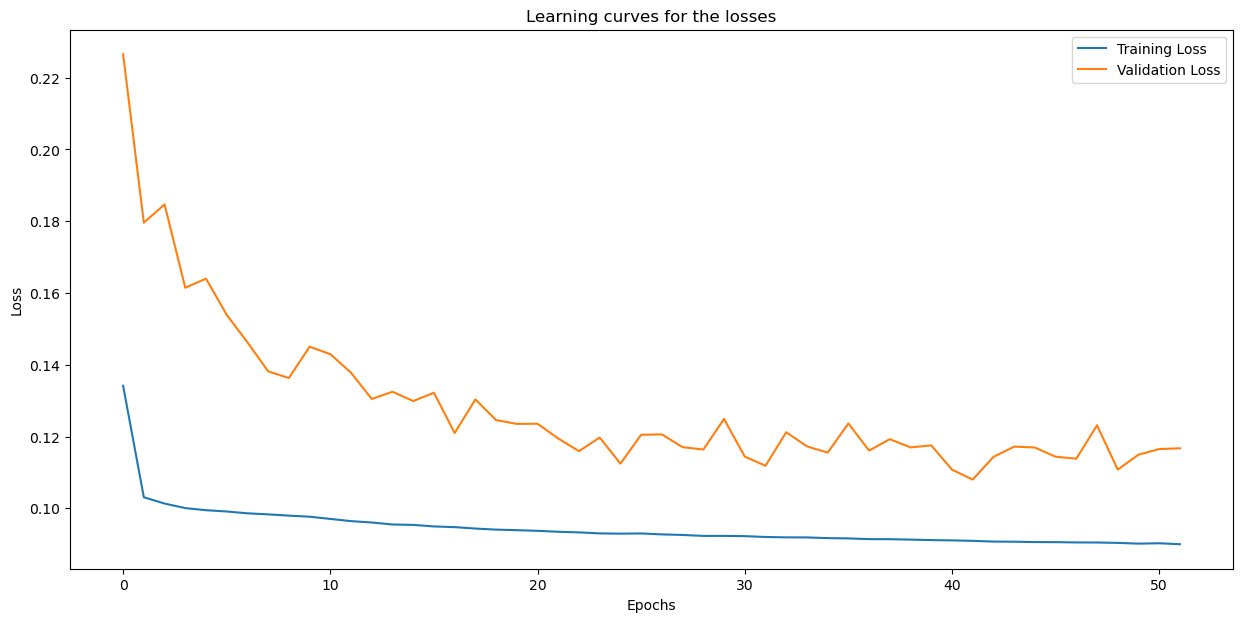

In [20]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

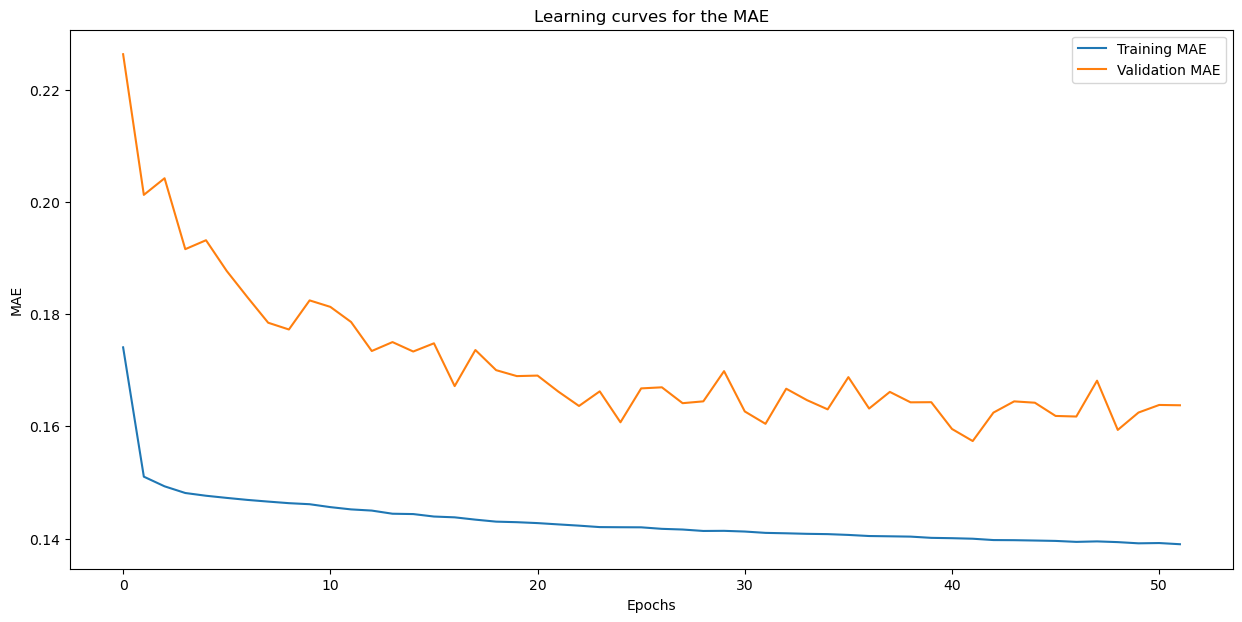

In [21]:
# plot the maes
plt.figure(figsize = (15,7))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Learning curves for the MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [22]:
# Now unfreeze the last CNN layer
CNN_model.trainable = True

set_trainable = False

for layer in CNN_model.layers:
    if layer.name == 'conv2d_3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
CNN_seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [24]:
%%time

# Same here, we are just running it for 2 epochs for the sake of completion with a patience of 1 - we will properly trin the model overnight. 
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0009)
CNN_seq2seq_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])
    
# add early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=10)

# fit the generator - the steps are a must here
history_new = CNN_seq2seq_model.fit(train_gen,
          validation_data = val_gen, steps_per_epoch=steps_per_epoch, 
                                  validation_steps=validation_steps,           
          epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-15 20:20:39.290321: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1536/1536 [==============================] - 59s 36ms/step - loss: 0.0951 - mean_absolute_error: 0.1437 - val_loss: 0.1080 - val_mean_absolute_error: 0.1555
Epoch 2/100
1536/1536 [==============================] - 56s 36ms/step - loss: 0.0939 - mean_absolute_error: 0.1427 - val_loss: 0.1046 - val_mean_absolute_error: 0.1524
Epoch 3/100
1536/1536 [==============================] - 56s 36ms/step - loss: 0.0924 - mean_absolute_error: 0.1413 - val_loss: 0.1058 - val_mean_absolute_error: 0.1545
Epoch 4/100
1536/1536 [==============================] - 56s 36ms/step - loss: 0.0914 - mean_absolute_error: 0.1403 - val_loss: 0.1114 - val_mean_absolute_error: 0.1594
Epoch 5/100
1536/1536 [==============================] - 56s 36ms/step - loss: 0.0906 - mean_absolute_error: 0.1396 - val_loss: 0.1059 - val_mean_absolute_error: 0.1541
Epoch 6/100
1536/1536 [==============================] - 56s 36ms/step - loss: 0.0900 - mean_absolute_error: 0.1390 - val_loss: 0.1031 - val_mean_absolute_error: 0.151

In [25]:
# save this model as keras? resave this after running it properly

# save this model
model_name_finetuned = 'CNN_seq2seq_overlapping.keras'
CNN_seq2seq_model.save('models' + '/' + model_name_finetuned)

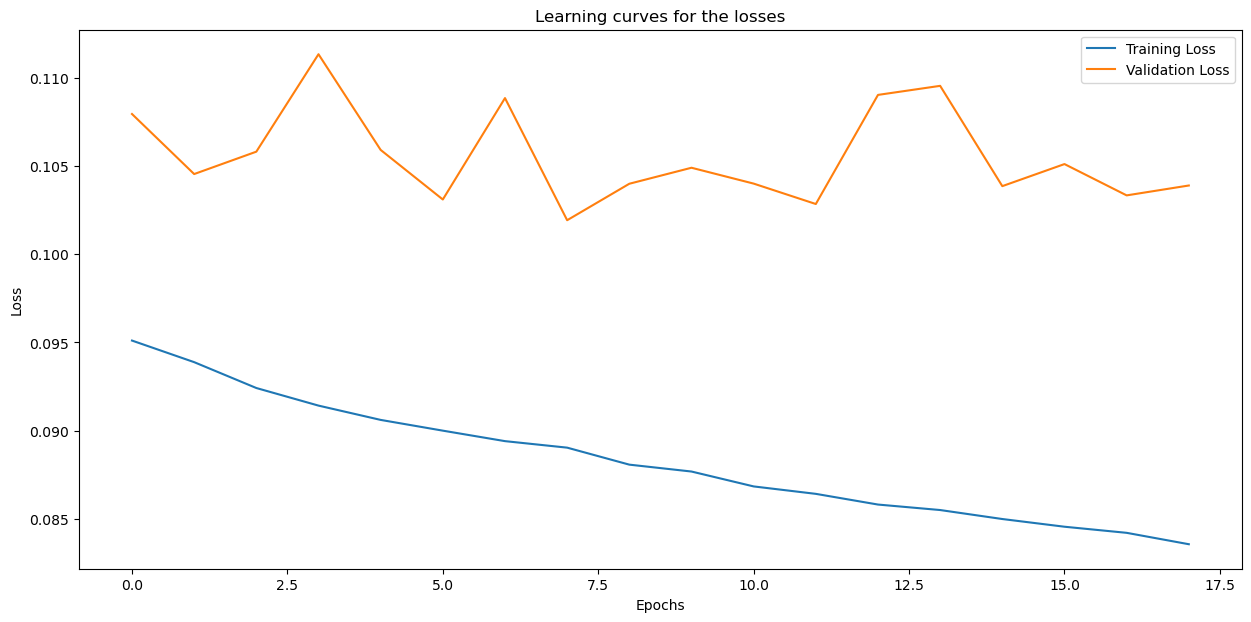

In [26]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

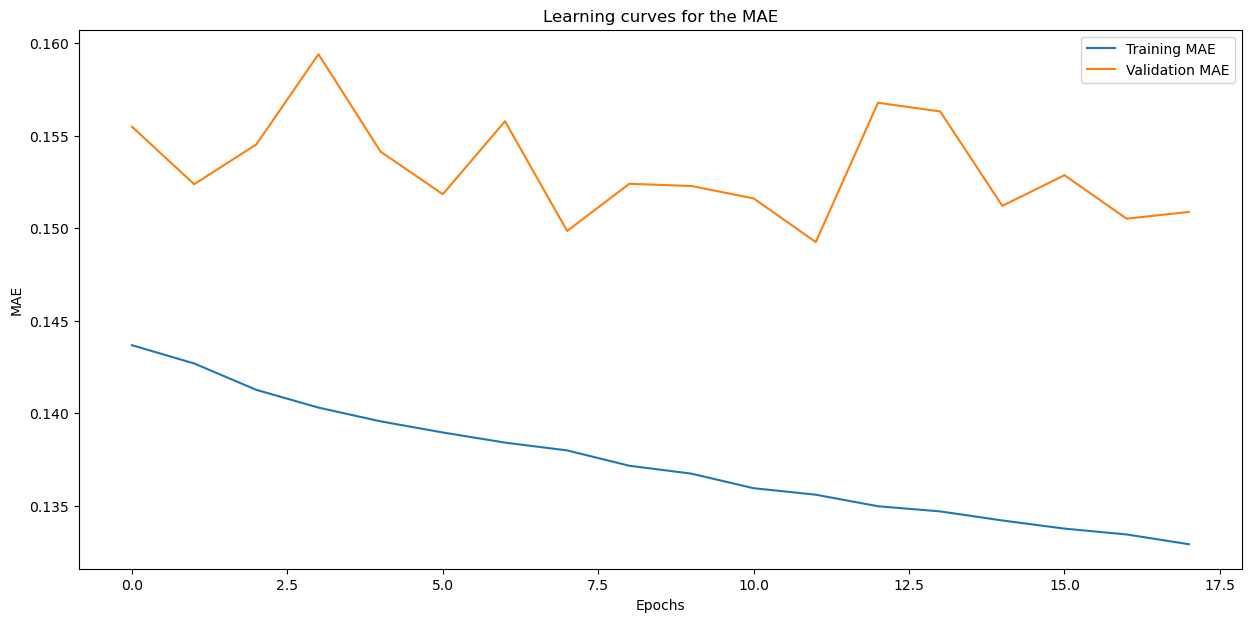

In [27]:
# plot the maes
plt.figure(figsize = (15,7))
plt.plot(history_new.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_new.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Learning curves for the MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()